#Finetune Recurrent Neural Network with GridSearch() class


###Reference

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

###Mounting to Google Drive


In [ ]:
#connecting gdrive into the google colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Import Libraries

In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers.recurrent import LSTM
from keras.layers import Activation, Dense, Dropout, Flatten, SimpleRNN
from keras.constraints import max_norm
from keras import layers

import numpy as np
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt

####Load the Dataset


In [ ]:
# change file path accordingly 
data=pd.read_csv("/content/gdrive/MyDrive/Depression Project/DepressionDataFinal2Processed.csv")
data = data.astype(str)
data.head()

,Id,Text,Target
0,2.85e+17,one thing love life mother one ever come mine,1
1,2.9e+17,want perfect want happy,0
2,2.86e+17,mom hates dad hates today sucks fword life tho,0
3,2.86e+17,hate hate life,0
4,2.86e+17,feel good,1


In [ ]:
data.columns

Index(['Id', 'Text', 'Target'], dtype='object')

### Train, Val, Test split --> 60%, 20%, 20% 

In [ ]:
# x_train is the training data set
# y_train is the corresponding labels to x_train 
# x_test is the test dataset 
# y_test is the corresponding label to x_test 
x_train, x_test, y_train, y_test = train_test_split(data, data.Target, test_size=0.2, random_state=1)
# 0.25 x 0.8 = 0.2
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) 

### Find Maximum Length of Tweets - max_len constant



In [ ]:
# find maximum length of tweet
def max_len(x):
    a=x.split()
    return len(a)

max(data['Text'].apply(max_len))

20

In [ ]:
# maxlen = 700 --> maximum length of tweet = 697
max_len = 20

### Convert Label into Term-Document Matrix

In [ ]:
# Bag of Words used to one-hot encode Target label 
# use CountVectorizer to covert the label into tokens
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(","), binary='true')
y_train=vectorizer.fit_transform(x_train['Target']).toarray()
y_test=vectorizer.fit_transform(x_test['Target']).toarray()
y_val=vectorizer.fit_transform(x_val['Target']).toarray()

### Tokenize tweets using Tokenizer()

In [ ]:
vect=Tokenizer()
vect.fit_on_texts(data['Text'])

### Find Size of Vectorized Tokens  - vocab_size constant



In [ ]:
vocab_size = len(vect.word_index) + 1
print(vocab_size)

1989


### Turn the Vectorized Tokens into Sequences of Integers


In [ ]:
encoded_docs_train = vect.texts_to_sequences(x_train['Text'])
encoded_docs_test =  vect.texts_to_sequences(x_test['Text'])
encoded_docs_cv = vect.texts_to_sequences(x_val['Text'])

### Padding and Making all the Sequences the same Length

In [ ]:
padded_docs_train = pad_sequences(encoded_docs_train, maxlen=max_len, padding='post')
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=max_len, padding='post')
padded_docs_cv = pad_sequences(encoded_docs_cv, maxlen=max_len, padding='post')

## Find Optimum Epoch and Batch Size 

In [ ]:
# Use scikit-learn to grid search the batch size and epochs

# Function to create model, required for KerasClassifier
def create_model():
	# create model
  model = Sequential()
  # Configuring the parameters
  model.add(Embedding(vocab_size, output_dim=50, input_length=max_len))
  model.add(layers.Bidirectional(layers.GRU(32)))
  model.add(Dropout(0.2)) 
  # Adding a dense output layer with sigmoid activation
  model.add(Dense(2, activation='sigmoid'))
	# Compile model
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [64, 128, 256, 512, 1024]
epochs = [25]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(padded_docs_train, y_train, validation_data = (padded_docs_cv, y_val))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.914729 using {'batch_size': 512, 'epochs': 25}
0.907733 (0.001872) with: {'batch_size': 64, 'epochs': 25}
0.906977 (0.002122) with: {'batch_size': 128, 'epochs': 25}
0.911893 (0.003507) with: {'batch_size': 256, 'epochs': 25}
0.914729 (0.002941) with: {'batch_size': 512, 'epochs': 25}
0.910191 (0.002139) with: {'batch_size': 1024, 'epochs': 25}


## Tune Optimisation Algorithm 

In [ ]:
# Function to create model, required for KerasClassifier
def create_model(optimizer='adam'):
  model = Sequential()
  # Configuring the parameters
  model.add(Embedding(vocab_size, output_dim=50, input_length=max_len))
  model.add(layers.Bidirectional(layers.GRU(32)))
  model.add(Dropout(0.2)) 
  # Adding a dense output layer with sigmoid activation
  model.add(Dense(2, activation='sigmoid'))
  # Compile model 
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# create model
model = KerasClassifier(build_fn=create_model, epochs=25, batch_size=512, verbose=0)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(padded_docs_train, y_train, validation_data = (padded_docs_cv, y_val))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.916998 using {'optimizer': 'Nadam'}
0.531669 (0.019220) with: {'optimizer': 'SGD'}
0.908678 (0.009401) with: {'optimizer': 'RMSprop'}
0.513897 (0.012692) with: {'optimizer': 'Adagrad'}
0.526754 (0.037057) with: {'optimizer': 'Adadelta'}
0.916052 (0.000926) with: {'optimizer': 'Adam'}
0.899792 (0.003939) with: {'optimizer': 'Adamax'}
0.916998 (0.003350) with: {'optimizer': 'Nadam'}


## Tune Neuron Activation Function


In [ ]:
def create_model(activation='relu'):
	# create model
  model = Sequential()
  # Configuring the parameters
  model.add(Embedding(vocab_size, output_dim=50, input_length=max_len))
  model.add(layers.Bidirectional(layers.GRU(32)))
  model.add(Dropout(0.2)) 
  # Adding a dense output layer with sigmoid activation
  model.add(Dense(2, activation='sigmoid'))
  model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])
	# Compile model
  return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# create model
model = KerasClassifier(build_fn=create_model, epochs=25, batch_size=512, verbose=0)
# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(padded_docs_train, y_train, validation_data = (padded_docs_cv, y_val))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.916241 using {'activation': 'softmax'}
0.916241 (0.001928) with: {'activation': 'softmax'}
0.916241 (0.001070) with: {'activation': 'softplus'}
0.915296 (0.005101) with: {'activation': 'softsign'}
0.915107 (0.000964) with: {'activation': 'relu'}
0.905275 (0.006566) with: {'activation': 'tanh'}
0.915863 (0.002088) with: {'activation': 'sigmoid'}
0.914161 (0.002377) with: {'activation': 'hard_sigmoid'}
0.908867 (0.007386) with: {'activation': 'linear'}


## Tune Learning Rate and Momentum

In [ ]:
def create_model(learn_rate=0.01, momentum=0):
  # create model
  model = Sequential()
  # Configuring the parameters
  model.add(Embedding(vocab_size, output_dim=50, input_length=max_len))
  model.add(layers.Bidirectional(layers.GRU(32)))
  model.add(Dropout(0.2)) 
  # Adding a dense output layer with sigmoid activation
  model.add(Dense(2, activation='softmax'))
  model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])
  return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
model = KerasClassifier(build_fn=create_model, epochs=25, batch_size=512, verbose=0)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(learn_rate=learn_rate, momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(padded_docs_train, y_train, validation_data = (padded_docs_cv, y_val))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.917754 using {'learn_rate': 0.1, 'momentum': 0.2}
0.912838 (0.004377) with: {'learn_rate': 0.001, 'momentum': 0.0}
0.913783 (0.001389) with: {'learn_rate': 0.001, 'momentum': 0.2}
0.912082 (0.002579) with: {'learn_rate': 0.001, 'momentum': 0.4}
0.900170 (0.013042) with: {'learn_rate': 0.001, 'momentum': 0.6}
0.915863 (0.002189) with: {'learn_rate': 0.001, 'momentum': 0.8}
0.907544 (0.006727) with: {'learn_rate': 0.001, 'momentum': 0.9}
0.912649 (0.000463) with: {'learn_rate': 0.01, 'momentum': 0.0}
0.911704 (0.006701) with: {'learn_rate': 0.01, 'momentum': 0.2}
0.909057 (0.004402) with: {'learn_rate': 0.01, 'momentum': 0.4}
0.916430 (0.005486) with: {'learn_rate': 0.01, 'momentum': 0.6}
0.912460 (0.002189) with: {'learn_rate': 0.01, 'momentum': 0.8}
0.915863 (0.003993) with: {'learn_rate': 0.01, 'momentum': 0.9}
0.910191 (0.006322) with: {'learn_rate': 0.1, 'momentum': 0.0}
0.917754 (0.001670) with: {'learn_rate': 0.1, 'momentum': 0.2}
0.903384 (0.009652) with: {'learn_rate': 0

## Tune Dropout Regularization

In [ ]:
def create_model(dropout_rate=0.0, weight_constraint=0):
	# create model
  model = Sequential()
  # Configuring the parameters
  model.add(Embedding(vocab_size, output_dim=50, input_length=max_len))
  model.add(layers.Bidirectional(layers.GRU(32)))
  model.add(Dropout(0.2))
  # Adding a dense output layer with sigmoid activation
  model.add(Dense(2, activation='softmax'))
  model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])
	# Compile model
  return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
model = KerasClassifier(build_fn=create_model, epochs=25, batch_size=512, verbose=0)
# define the grid search parameters
weight_constraint = [1, 2, 3, 4, 5]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(dropout_rate=dropout_rate, weight_constraint=weight_constraint)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(padded_docs_train, y_train, validation_data = (padded_docs_cv, y_val))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.917754 using {'dropout_rate': 0.7, 'weight_constraint': 3}
0.914351 (0.002451) with: {'dropout_rate': 0.0, 'weight_constraint': 1}
0.909624 (0.004685) with: {'dropout_rate': 0.0, 'weight_constraint': 2}
0.914918 (0.001670) with: {'dropout_rate': 0.0, 'weight_constraint': 3}
0.906788 (0.008132) with: {'dropout_rate': 0.0, 'weight_constraint': 4}
0.900170 (0.009570) with: {'dropout_rate': 0.0, 'weight_constraint': 5}
0.913972 (0.001415) with: {'dropout_rate': 0.1, 'weight_constraint': 1}
0.910947 (0.002779) with: {'dropout_rate': 0.1, 'weight_constraint': 2}
0.912082 (0.007791) with: {'dropout_rate': 0.1, 'weight_constraint': 3}
0.908867 (0.010171) with: {'dropout_rate': 0.1, 'weight_constraint': 4}
0.910191 (0.009359) with: {'dropout_rate': 0.1, 'weight_constraint': 5}
0.910569 (0.007090) with: {'dropout_rate': 0.2, 'weight_constraint': 1}
0.910191 (0.000964) with: {'dropout_rate': 0.2, 'weight_constraint': 2}
0.908300 (0.011432) with: {'dropout_rate': 0.2, 'weight_constraint': 

## Tune Network Weight Initialization

In [ ]:
def create_model(init_mode= 'uniform'):
	# create model
  model = Sequential()
  # Configuring the parameters
  model.add(Embedding(vocab_size, output_dim=50, input_length=max_len))
  model.add(layers.Bidirectional(layers.GRU(32)))
  model.add(Dropout(0.2))
  # Adding a dense output layer with sigmoid activation
  model.add(Dense(2, activation='softmax', kernel_initializer=init_mode))
  model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])
	# Compile model
  return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
model = KerasClassifier(build_fn=create_model, epochs=25, batch_size=512, verbose=0)
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(init_mode=init_mode)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(padded_docs_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.914918 using {'init_mode': 'lecun_uniform'}
0.913594 (0.004662) with: {'init_mode': 'uniform'}
0.914918 (0.003957) with: {'init_mode': 'lecun_uniform'}
0.907733 (0.007444) with: {'init_mode': 'normal'}
0.905464 (0.011774) with: {'init_mode': 'zero'}
0.912649 (0.004879) with: {'init_mode': 'glorot_normal'}
0.914351 (0.000802) with: {'init_mode': 'glorot_uniform'}
0.905842 (0.005219) with: {'init_mode': 'he_normal'}
0.913027 (0.005602) with: {'init_mode': 'he_uniform'}


## Tune the Number of Neurons in the Hidden Layer

In [ ]:
def create_model(neurons=1):
	# create model
  model = Sequential()
  # Configuring the parameters
  model.add(Embedding(vocab_size, output_dim=50, input_length=max_len))
  model.add(layers.Bidirectional(layers.GRU(32)))
  model.add(Dropout(0.2))
  # Adding a dense output layer with sigmoid activation
  model.add(Dense(2, activation='softmax', kernel_initializer='he_uniform'))
  model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])
	# Compile model
  return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
model = KerasClassifier(build_fn=create_model, epochs=25, batch_size=512, verbose=0)
# define the grid search parameters
neurons = [25, 30, 35, 40, 45, 50, 100]
param_grid = dict(neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(padded_docs_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.917187 using {'neurons': 30}
0.914729 (0.005205) with: {'neurons': 25}
0.917187 (0.000463) with: {'neurons': 30}
0.908489 (0.008405) with: {'neurons': 35}
0.913783 (0.003497) with: {'neurons': 40}
0.912838 (0.004202) with: {'neurons': 45}
0.911514 (0.002019) with: {'neurons': 50}
0.915674 (0.001489) with: {'neurons': 100}


### Build and compile DL Model

In [ ]:
model = Sequential()
# Configuring the parameters
model.add(Embedding(vocab_size, output_dim=50, input_length=max_len))
model.add(layers.Bidirectional(layers.GRU(32)))
model.add(Dropout(0.7))
model.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model.add(Dense(2, activation='softmax', kernel_initializer='lecun_uniform'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 20, 50)            99450     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 64)                16128     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 130       
Total params: 115,708
Trainable params: 115,708
Non-trainable params: 0
_________________________________________________________________


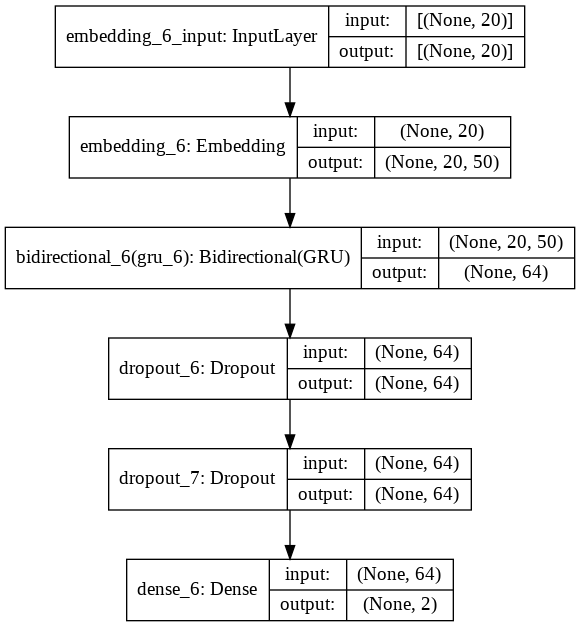

In [ ]:
# plot NN model 
plot_model(model, to_file='/content/gdrive/MyDrive/Depression Project/mlp-mnist.png', show_shapes=True)

In [ ]:
# compile the model 
model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(padded_docs_train, y_train,
                    epochs=25, batch_size=512, 
                    validation_data = (padded_docs_cv, y_val)
                    )

Epoch 1/25
11/11 [==============================] - 3s 66ms/step - loss: 0.6897 - accuracy: 0.5383 - val_loss: 0.6768 - val_accuracy: 0.5468
Epoch 2/25
11/11 [==============================] - 0s 12ms/step - loss: 0.6722 - accuracy: 0.6149 - val_loss: 0.6490 - val_accuracy: 0.7311
Epoch 3/25
11/11 [==============================] - 0s 13ms/step - loss: 0.6400 - accuracy: 0.7056 - val_loss: 0.5932 - val_accuracy: 0.7981
Epoch 4/25
11/11 [==============================] - 0s 12ms/step - loss: 0.5799 - accuracy: 0.7983 - val_loss: 0.5180 - val_accuracy: 0.8786
Epoch 5/25
11/11 [==============================] - 0s 12ms/step - loss: 0.5173 - accuracy: 0.8478 - val_loss: 0.4510 - val_accuracy: 0.8911
Epoch 6/25
11/11 [==============================] - 0s 13ms/step - loss: 0.4567 - accuracy: 0.8700 - val_loss: 0.4008 - val_accuracy: 0.9047
Epoch 7/25
11/11 [==============================] - 0s 12ms/step - loss: 0.4067 - accuracy: 0.8864 - val_loss: 0.3516 - val_accuracy: 0.9121
Epoch 8/25
11

### Evaluate the Model


In [ ]:
model.evaluate(padded_docs_test, y_test)

56/56 [==============================] - 0s 3ms/step - loss: 0.3440 - accuracy: 0.8973


[0.3439598083496094, 0.897334098815918]

### Plot Results in a Graph 

In [ ]:
# Read as a dataframe 
metrics = pd.DataFrame(history.history)
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

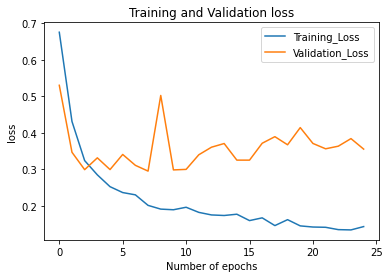

In [ ]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

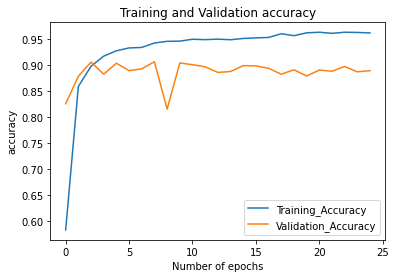

In [ ]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')